In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp /content/drive/'My Drive'/kaggle.json .
!cp /content/drive/'My Drive'/tweeter/utils_for_ml.py .

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!kaggle competitions download -c nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import CountVectorizer
from utils_for_ml import *

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

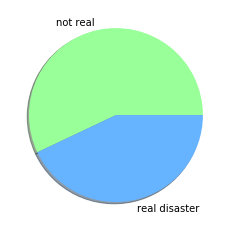

In [0]:
x = train['target'].value_counts()
plt.pie(x, labels = ['not real', 'real disaster'], shadow=True, colors = ['#99ff99','#66b3ff'])
plt.show()

We have a deal with unbalanced dataset.

After reading the data we can extract **hashtags** from tweets:

In [0]:
train['tags'] = train['text'].str.findall(r'#.*?(?=\s|$)')
test['tags'] = test['text'].str.findall(r'#.*?(?=\s|$)')

In [0]:
train.head(10)

,id,keyword,location,text,target,tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[#earthquake]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[#wildfires]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[#Alaska, #wildfires]"
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,"[#RockyFire, #CAfire, #wildfires]"
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,"[#flood, #disaster]"
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,[]
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,[]
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,[]


##Data Analysis:

To explore tags in train and test I will collect them in to np.arrays:

In [0]:
tags_in_train = np.array([])
for tags in train['tags'].values:
  tags_in_train = np.append(tags_in_train, tags)

tags_in_test = np.array([])
for tags in test['tags'].values:
  tags_in_test = np.append(tags_in_test, tags)

Doing lowercase to all of them:

In [0]:
tags_in_train = [tag.lower() for tag in tags_in_train]
tags_in_test = [tag.lower() for tag in tags_in_test]  

As we want to get more the same tags, we will do lemmatization then, to do it let's replace '#':

In [0]:
tags_in_train = [tag.replace('#', '') for tag in tags_in_train]
tags_in_test = [tag.replace('#', '') for tag in tags_in_test]

I will save it to new arrays to have the ability to compare with tags with no lemmatization:

In [0]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

lem_in_train = [lem.lemmatize(tag) for tag in tags_in_train]
lem_in_test = [lem.lemmatize(tag) for tag in tags_in_test]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Amounts without lemmatization:

In [0]:
print(('Number tags in train:          {}\n'+\
       'Number unique tags in train:   {}\n'+\
       'Number tags in test:           {}\n'+\
       'Number unique tags in test:    {}\n')
       .format(len(tags_in_train), 
       len(np.unique(tags_in_train)), 
       len(tags_in_test), 
       len(np.unique(tags_in_test))))

Number tags in train:          3384
Number unique tags in train:   1988
Number tags in test:           1535
Number unique tags in test:    1155



And with lemmatization:

In [0]:
print(('Number tags in train afret lematization:          {}\n'+\
       'Number unique tags in train afret lematization:   {}\n'+\
       'Number tags in test afret lematization:           {}\n'+\
       'Number unique tags in test afret lematization:    {}\n') 
       .format(len(lem_in_train), 
       len(np.unique(lem_in_train)), 
       len(lem_in_test), 
       len(np.unique(lem_in_test))))

Number tags in train afret lematization:          3384
Number unique tags in train afret lematization:   1964
Number tags in test afret lematization:           1535
Number unique tags in test afret lematization:    1143



We can see pretty similar results, so let's have a look at the **intersection** of tags in a train and tags in a test, as we will use just them for our model:

In [0]:
intersect = np.intersect1d(tags_in_test, tags_in_train)

In [0]:
lem_intersect = np.intersect1d(lem_in_test, lem_in_train)

In [0]:
print(('Number of tags in intersect of train and test:                      {}\n'+\
       'Number of tags in intersect of train and test afret lematization:   {}')
       .format(len(intersect), len(lem_intersect)))

Number of tags in intersect of train and test:                      409
Number of tags in intersect of train and test afret lematization:   406


As we can see, lemmatization didn't give me that I aspect, just on 3 words less. Let's make a good visualization to show it:

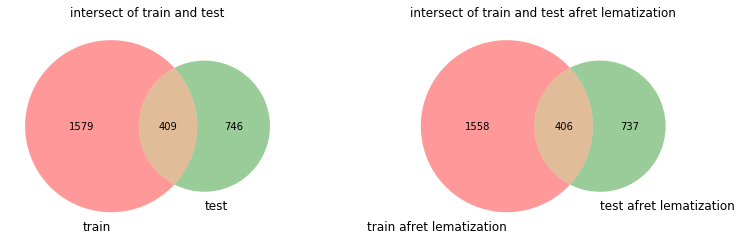

In [0]:
plt.figure(figsize=(13,13))

plt.subplot(321)
venn2([set(tags_in_train), set(tags_in_test)], set_labels=('train', 'test'))
plt.title('intersect of train and test')

plt.subplot(322)
venn2([set(lem_in_train), set(lem_in_test)], set_labels=('train afret lematization', 'test afret lematization'))
plt.title('intersect of train and test afret lematization')
plt.show()


Let's try to use stemming:

In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

stem_in_train = [stemmer.stem(tag) for tag in tags_in_train]
stem_in_test = [stemmer.stem(tag) for tag in tags_in_test]

In [0]:
print(('Number unique tags in train afret stemming:  {}\n'+\
       'Number unique tags in test afret stemming:   {}\n') 
       .format(len(np.unique(stem_in_train)), 
       len(np.unique(stem_in_test))))

Number unique tags in train afret stemming:  1946
Number unique tags in test afret stemming:   1138



In [0]:
stem_intersect = np.intersect1d(stem_in_test, stem_in_train)

In [0]:
print('Number of tags in intersect of train and test afret stemming:  {}'
      .format(len(stem_intersect)))

Number of tags in intersect of train and test afret stemming:  408


So, stemming didn't give me, that I expected to...

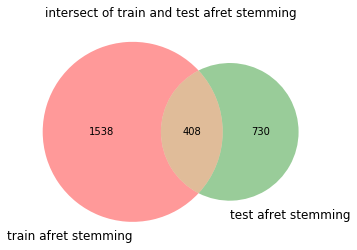

In [0]:
venn2([set(stem_in_train), set(stem_in_test)], set_labels=('train afret stemming', 'test afret stemming'))
plt.title('intersect of train and test afret stemming')
plt.show()

Thus, stemming and lemmatization gave almost the same number of intersect of train and test tags, so I will use original tags.

##Data Preprocessing

Let's drop unnecessary tags:

In [0]:
train['tags'] = train['tags'].apply(lambda tags: [tag.lower().replace('#', '') for tag in tags if tag.lower().replace('#', '') in intersect])
test['tags'] = test['tags'].apply(lambda tags: [tag.lower().replace('#', '') for tag in tags if tag.lower().replace('#', '') in intersect])

As some of tweets have no tags and some have more than one, let's have a look at the max number of tags in train:

In [0]:
train['tags'].apply(lambda tags: len(tags)).max()

10

And in test:

In [0]:
test['tags'].apply(lambda tags: len(tags)).max()

10

We got the same max number.

In [0]:
train.head()

,id,keyword,location,text,target,tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,[wildfires]


To vectorize all tag's lists I will use CountVectorizer, so I will do some preprocessing to use it:

In [0]:
detokenized_train = [] 
for i in range(len(train)): 
    tags = ' '.join(train['tags'].values[i]) 
    detokenized_train.append(tags)

detokenized_test = [] 
for i in range(len(test)): 
    tags = ' '.join(test['tags'].values[i]) 
    detokenized_test.append(tags)

train['tags'] = detokenized_train
test['tags'] = detokenized_test

In [0]:
vectorizer = CountVectorizer(lowercase=False, token_pattern='\\b(\w+(\S|\\.)?)+\\b')

In [0]:
vectorizer.fit_transform(train['tags'])

<7613x398 sparse matrix of type '<class 'numpy.int64'>'
	with 1404 stored elements in Compressed Sparse Row format>

We have to get a 7613x409 matrix but got 7613x398. It's mean, that some of the tags weren't coded, to find them, I will use setdiff1d: 

In [0]:
np.setdiff1d(vectorizer.get_feature_names(), intersect)

array(['-', '3', '4playthursdays', '_', 'bestnaijamade', 'manchester',
       'nikeplus', 'ok', 'ramag', 'trauma', '\x89', 'û', 'û_', 'ûªs'],
      dtype='<U27')

As an example, we have "manchester**.**" in an uncoded list, but have no "manchester" there. So, I will fix it.

In [0]:
print('manchester' in intersect)
print('manchester.' in intersect)

False
True


In [0]:
labels = train['target']

features = vectorizer.fit_transform(train['tags']).toarray()
test_features = vectorizer.fit_transform(test['tags']).toarray()

##Model

In the previous time, I user Random Forest which gave F1 ~ 0.17, but I decided to try  KNN and it was really good decision.

In [0]:
train_prediction = cross_val(features,
                             labels,
                             model_type = 'knn',
                             n_estimators = 50,
                             print_feature_importances = False,
                             k_neighbors = 9, 
                             n_folds = 5)


Training Data Shape:  (7613, 398)

F1 Score: 0.5971428571428572


Creating datasets for predictions:

In [0]:
prediction = train.copy()

prediction['tags_pred'] = train_prediction
prediction = prediction.drop(columns = ['keyword', 'location', 'text', 'tags'])

In [0]:
prediction.head()

,id,target,tags_pred
0,1,1,0.888889
1,4,1,0.666667
2,5,1,0.777778
3,6,1,0.777778
4,7,1,0.777778


Let's fit our model at all dataset and get prediction for test:

In [0]:
model = KNeighborsClassifier(n_neighbors=9)

model.fit(features, labels)

test_prediction = model.predict_proba(test_features)

In [0]:
test_predictions = test.copy()

test_predictions['tags_pred'] = test_prediction[:, 1]

test_predictions = test_predictions.drop(columns = ['keyword', 'location', 'text', 'tags'])

In [0]:
test_predictions.head()

,id,tags_pred
0,0,0.777778
1,2,1.000000
2,3,0.777778
3,9,0.888889
4,11,0.777778


In [0]:
prediction.to_csv('/content/drive/My Drive/tweeter/train_predictions_tags.csv', index_label='idx')
test_predictions.to_csv('/content/drive/My Drive/tweeter/test_predictions_tags.csv', index_label='idx')